<a href="https://colab.research.google.com/github/AnDiMawigo/UniMol_test_example/blob/main/UniMol_test_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uni-Mol Finetune-Property Prediction

<a href="https://colab.research.google.com/github/LicoriceLin/NMDA_deeplearning_example/blob/master/unimol-demo-bbb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set up the Environments

Download necessary packages and dependencies, including unicore and Uni-Mol from GitHub, as well as additional libraries such as RDKit, BioPandas, and Py3Dmol.Fetches pre-trained weights for the project. Ensure that the setup is performed only once by checking the existence of a file named `UNIMOL_READY` and create it after the setup is completed.


In [1]:
%%bash

export NCCL_ASYNC_ERROR_HANDLING=1
export OMP_NUM_THREADS=1

cd /content
GIT_REPO='https://github.com/dptech-corp/Uni-Mol.git'
UNICORE_URL='https://github.com/dptech-corp/Uni-Core/releases/download/0.0.2/unicore-0.0.1+cu113torch1.12.0-cp310-cp310-linux_x86_64.whl'
WEIGHT_URL='https://github.com/dptech-corp/Uni-Mol/releases/download/v0.1/mol_pre_no_h_220816.pt'
if [ ! -f UNIMOL_READY ]; then
  wget -q ${UNICORE_URL}
  pip3 -q install "unicore-0.0.1+cu113torch1.12.0-cp310-cp310-linux_x86_64.whl"
  git clone -b main ${GIT_REPO}
  cd ./Uni-Mol/unimol
  python setup.py develop
  cd -
  pip install -q rdkit
  pip install -q biopandas
  pip install -q py3Dmol
  git clone https://github.com/AnDiMawigo/UniMol_test_example.git
  wget -q ${WEIGHT_URL}

  touch UNIMOL_READY
fi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 27.5 MB/s eta 0:00:00
running develop
running egg_info
creating unimol.egg-info
writing unimol.egg-info/PKG-INFO
writing dependency_links to unimol.egg-info/dependency_links.txt
writing requirements to unimol.egg-info/requires.txt
writing top-level names to unimol.egg-info/top_level.txt
writing manifest file 'unimol.egg-info/SOURCES.txt'
reading manifest file 'unimol.egg-info/SOURCES.txt'
writing manifest file 'unimol.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.10/dist-packages/unimol.egg-link (link to .)
Adding unimol 1.0.0 to easy-install.pth file

Installed /content/Uni-Mol/unimol


Cloning into 'Uni-Mol'...
/usr/local/lib/python3.10/dist-packages/setuptools/command/develop.py:40: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://github.com/pypa/setuptools/issues/917 for details.
        ********************************************************************************

!!
  easy_install.initialize_options(self)
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-base

# Preprocess
Load a .csv file located at `data_path` and performs preprocessing steps if LMDB files for training and testing are not already present. Set certain parameters, such as the loss function and the metric to evaluate the model.<br>



## Parameter
 `data_path`: a .csv file in this case.
 its 1st columns is the smiles string of molelules,and the 2rd colum is the target function to fit on. Automatically split the input into train/valid/test set with a ratio of 8:1:1<br>
`num_classes`: How many class in claasification task.<br>
`seed`: Random seed (integer) to split train/valid/test set and generate conformation.




In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla T4


In [3]:
data_path='/content/UniMol_test_example/mol_train.csv'
seed=43

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
os.chdir('/content')

_=data_path.replace('.csv','')

for i in ['train','test']:
  f=os.path.join(_,f'{i}.lmdb')
  if not os.path.isfile(f):
    data = pd.read_csv(data_path)
    train, val_test = train_test_split(data, test_size=0.2, random_state = seed)
    valid, test = train_test_split(val_test, test_size=0.5, random_state = seed)
    os.mkdir(_) if not os.path.exists(_) else None
    train.to_csv(os.path.join(_,'train.csv'), index=False)
    valid.to_csv(os.path.join(_,'valid.csv'), index=False)
    test.to_csv(os.path.join(_,'test.csv'), index=False)
    print('preprocessing...')
    state = 'train'
    !python UniMol_test_example/preprocess.py --data {data_path} --seed {seed} --state {state}

extra_paras='--maximize-best-checkpoint-metric '

# Training
Set various parameters for the training process. Launch the training process using Uni-Mol and saves the trained model and results in the specified directory. <br>
## Parameter
`fintune_weight_path`: path to pretrained model<br>
`only_polar`: corresponding to your pretrained model<br>
`batch_size`: change when cuda memory is under- or over- used.<br>
`epoch`:max epoch to train.<br>
`keep_last_epochs`: Only checkpoints in last N epoch will be kept for analysis.
this parameter defines the N value above.<br>
`lr`: learning rate,ratio between parameter increments and backward gradients.<br>
`dropout`: rate to randomly leave-out parametera to avoid overfitting.<br>
`warmup`: at the very first training steps, changing the learning rate
 according to this ratio.



In [4]:
import os, sys,shutil
data_dir,task_name=os.path.split(_)
if not data_dir:
  data_dir='.'
save_dir=os.path.join(data_dir,f'{task_name}_result')
os.environ['LOCAL_RANK'] = '1'
if os.path.isdir(save_dir):
  shutil.rmtree(save_dir)
os.makedirs(save_dir,exist_ok=True)
MASTER_PORT=10086
n_gpu=1
dict_name='/content/Uni-Mol/unimol/example_data/molecule/dict.txt'
fintune_weight_path='/content/mol_pre_no_h_220816.pt'
num_classes=2
loss_func="finetune_cross_entropy"
batch_size=32
epoch=15
keep_last_epochs=15
lr=1e-4
dropout=0.1
warmup=0.06
num_workers=0
local_batch_size=batch_size
only_polar=0
conf_size=11
seed=43
metric="valid_agg_auc"
update_freq=int(batch_size / local_batch_size)

!python -m torch.distributed.launch --nproc_per_node=$n_gpu --master_port $MASTER_PORT --use_env \
    $(which unicore-train) $data_dir --task-name $task_name --user-dir ./Uni-Mol/unimol \
      --train-subset train --valid-subset valid \
      --conf-size $conf_size \
      --num-workers $num_workers --ddp-backend=c10d \
      --dict-name $dict_name \
      --task mol_finetune --loss $loss_func --arch unimol_base  \
      --classification-head-name $task_name --num-classes $num_classes \
      --optimizer adam --adam-betas '(0.9, 0.99)' --adam-eps 1e-6 --clip-norm 1.0 \
      --lr-scheduler polynomial_decay --lr $lr --warmup-ratio $warmup --max-epoch $epoch \
      --batch-size $local_batch_size --pooler-dropout $dropout \
      --update-freq $update_freq --seed $seed \
      --fp16 --fp16-init-scale 4 --fp16-scale-window 256 \
      --log-interval 100 --log-format simple \
      --validate-interval 1 --keep-last-epochs $keep_last_epochs \
      --finetune-from-model $fintune_weight_path \
      --best-checkpoint-metric $metric --patience 20 \
      --save-dir $save_dir --only-polar $only_polar \
      --tensorboard-logdir $save_dir $extra_paras

/usr/local/lib/python3.10/dist-packages/torch/distributed/launch.py:181: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use-env is set by default in torchrun.
If your script expects `--local-rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  warnings.warn(
2023-07-15 23:43:27.161571: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-15 23:43:27.993130: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
fused_multi_tensor is not installed corrected
fused_rounding is not installed corrected
fused

Iterate over different checkpoint weights, perform inference using Uni-Mol's infer.py script.

In [5]:
test_file='/content/UniMol_test_example/mol_train/valid.lmdb'

import pandas as pd
from glob import glob
import re

infer_extra_paras=''
print(f'profile models in {save_dir}...')


def split_testfile(test_file):
    _,subset=os.path.split(test_file)
    subset=subset.replace('.lmdb','')
    result_path=os.path.join(_,subset+'_result')
    data_path,task_name=os.path.split(_)
    return data_path,task_name,subset,result_path

test_data_path,test_task_name,test_subset,test_result_path=split_testfile(test_file)

pts=glob(os.path.join(save_dir,f'*.pt'))
for infer_weight_path in pts:
  id=os.path.basename(infer_weight_path).replace('.pt','')
  flags=f'''--user-dir /content/Uni-Mol/unimol/unimol {test_data_path} \
    --task-name {test_task_name} --valid-subset {test_subset} \
    --results-path {test_result_path} \
    --num-workers 8 --ddp-backend=c10d --batch-size {batch_size} \
    --task mol_finetune --loss {loss_func} --arch unimol_base \
    --classification-head-name {task_name} --num-classes {num_classes} \
    --dict-name {dict_name} --conf-size {conf_size} \
    --only-polar {only_polar}  \
    --path {infer_weight_path}  \
    --fp16 --fp16-init-scale 4 --fp16-scale-window 256 \
    --log-interval 50 --log-format simple {infer_extra_paras}'''

  !python /content/Uni-Mol/unimol/unimol/infer.py $flags

  fname = infer_weight_path.split("/")[-2]
  save_path = os.path.join(test_result_path,
          fname + "_" + test_subset + ".out.pkl")


profile models in /content/UniMol_test_example/mol_train_result...
2023-07-15 23:46:54.139135: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-15 23:46:55.283215: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
fused_multi_tensor is not installed corrected
fused_rounding is not installed corrected
fused_layer_norm is not installed corrected
fused_softmax is not installed corrected
2023-07-15 23:46:58 | INFO | unimol.inference | loading model(s) from /content/UniMol_test_example/mol_train_result/checkpoint15.pt
2023-07-15 23:46:58 | INFO | unimol.tasks.unimol_finetune | dictionary: 30 types
2023-07-15 23:47:07 | INFO | unimol.inference | Namespace(no_progress_bar=False, log_interval=50, log_format='s

# Inference
Perform inference on the `test.lmdb` data split from the mol_train.csv file. Call Uni-Mol's infer.py script with the specified arguments to generate predictions.



In [6]:
data_path='/content/UniMol_test_example/mol_train/test.lmdb'
infer_weight_path='/content/UniMol_test_example/mol_train_result/checkpoint_last.pt'
batch_size=16
num_classes=2
loss_func="finetune_cross_entropy"
dict_name='/content/Uni-Mol/unimol/example_data/molecule/dict.txt'
conf_size=11
only_polar=0
seed=42
infer_extra_paras=''

import pandas as pd
from glob import glob
import re,os,shutil
import matplotlib.pyplot as plt
from sklearn.metrics import (roc_curve, roc_auc_score, precision_recall_curve,
                average_precision_score, confusion_matrix, ConfusionMatrixDisplay)

def get_csv_results(predict_path):
  predict = pd.read_pickle(predict_path)
  smi_list, predict_list,target_list = [], [], []
  for batch in predict:
      sz = batch["bsz"]
      for i in range(sz):
        smi_list.append(batch["smi_name"][i])
        predict_list.append(batch["prob"][i][1].tolist())
        target_list.append(batch['target'][i].tolist())
  predict_df = pd.DataFrame({"SMILES": smi_list, "predict": predict_list,"target":target_list})
  predict_df = predict_df.groupby("SMILES")[["predict","target"]].mean().reset_index()
  predict_df.to_csv(predict_path.replace('.out.pkl','.csv'),index=False)
  return predict_df

test_data_path,test_task_name,test_subset,test_result_path=split_testfile(data_path)

id=os.path.basename(infer_weight_path).replace('.pt','')
flags=f'''--user-dir /content/Uni-Mol/unimol/unimol {test_data_path} \
  --task-name {test_task_name} --valid-subset {test_subset} \
  --results-path {test_result_path} \
  --num-workers 8 --ddp-backend=c10d --batch-size {batch_size} \
  --task mol_finetune --loss {loss_func} --arch unimol_base \
  --classification-head-name {test_task_name} --num-classes {num_classes} \
  --dict-name {dict_name} --conf-size {conf_size} \
  --only-polar {only_polar}  \
  --path {infer_weight_path}  \
  --fp16 --fp16-init-scale 4 --fp16-scale-window 256 \
  --log-interval 50 --log-format simple {infer_extra_paras}'''

!python /content/Uni-Mol/unimol/unimol/infer.py $flags

fname = infer_weight_path.split("/")[-2]
save_path = os.path.join(test_result_path,
        fname + "_" + test_subset + ".out.pkl")
tmp_save_path=save_path.replace(".out.pkl",f".{id}.out.pkl")
shutil.move(save_path,tmp_save_path)
infer_result=get_csv_results(tmp_save_path)

2023-07-15 23:51:35.877708: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-15 23:51:36.971772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
fused_multi_tensor is not installed corrected
fused_rounding is not installed corrected
fused_layer_norm is not installed corrected
fused_softmax is not installed corrected
2023-07-15 23:51:39 | INFO | unimol.inference | loading model(s) from /content/UniMol_test_example/mol_train_result/checkpoint_last.pt
2023-07-15 23:51:40 | INFO | unimol.tasks.unimol_finetune | dictionary: 30 types
2023-07-15 23:51:43 | INFO | unimol.inference | Namespace(no_progress_bar=False, log_interval=50, log_format='simple', tensorboard_logdir='', seed=1, cpu=False, fp16=True, bf1

In [7]:
infer_result

,SMILES,predict,target
0,C1CCC(CC1)(CC(=O)O)CN,0.998325,1.0
1,C=CCN1CCc2c(sc(n2)N)CC1,0.981489,1.0
2,CC(=O)Nc1nnc(s1)S(=O)(=O)N,0.000379,1.0
3,CC(=O)OCCN1CCN(CC1)CCCN2c3ccccc3Sc4c2cc(cc4)Cl,0.998772,1.0
4,CC(=O)Oc1ccc2c3c1OC4C35CCN(C(C2)C5C=CC4OC(=O)C)C,0.994196,1.0
...,...,...,...
65,OS(=O)(=O)OCC1OC(OC2(COS(=O)(=O)O)OC(OS(=O)(=O...,0.000529,0.0
66,Oc1ccc(cc1)c2sc3cc(O)ccc3c2C(=O)c4ccc(OCCN5CCC...,0.179563,0.0
67,c1cc(ccc1C(=O)CCCN2CCC(CC2)(c3ccc(cc3)Br)O)F,0.315641,1.0
68,c1ccc(cc1)C2CC2N,0.998411,1.0


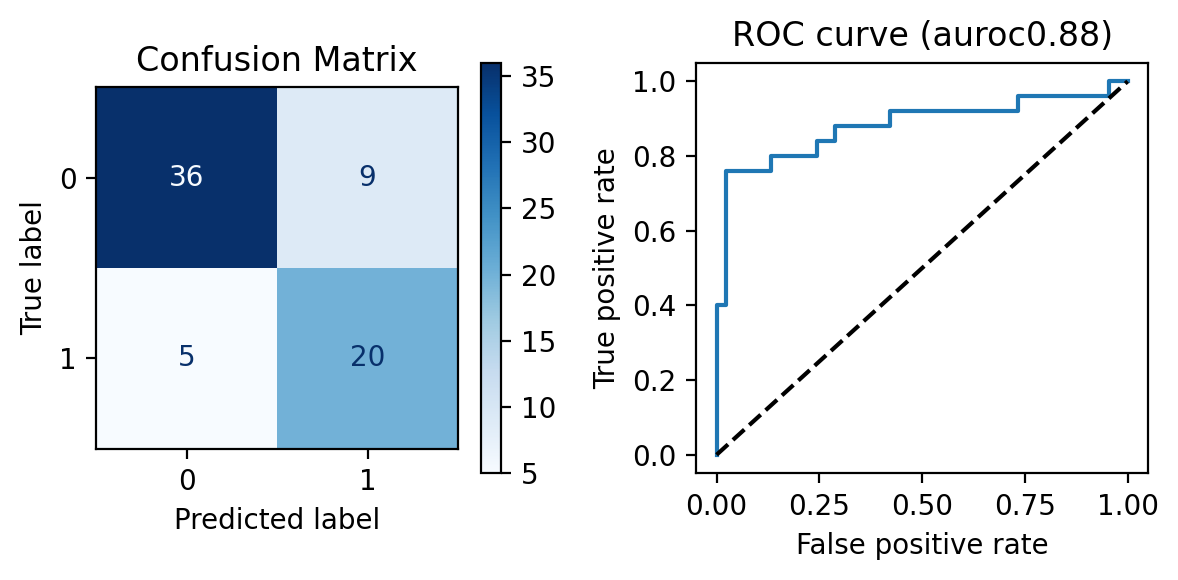

In [8]:
import matplotlib.pyplot as plt
import scipy
from math import ceil
from sklearn.metrics import (roc_curve, roc_auc_score,confusion_matrix,
                             ConfusionMatrixDisplay)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
fpr, tpr, _ = roc_curve(infer_result['target'], infer_result['predict'])

pred_label = [1 if i > 0.1 else 0 for i in infer_result['predict']]
cm = confusion_matrix(infer_result['target'], pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot(cmap='Blues', values_format='.0f',ax=axes[0])
axes[0].set_title('Confusion Matrix')

axes[1].plot(fpr, tpr)
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlabel('False positive rate')
axes[1].set_ylabel('True positive rate')
auroc = roc_auc_score(infer_result['target'], infer_result['predict'])
axes[1].set_title(f'ROC curve (auroc{auroc:.2f})')

fig.set_dpi(200)
plt.tight_layout()
plt.show()

Perform inference on the `mol_test.lmdb` data. The prediction results are saved in `mol_submission.csv`.

In [ ]:
data_path='/content/UniMol_test_example/mol_train/mol_test.lmdb'
infer_weight_path='/content/UniMol_test_example/mol_train_result/checkpoint_last.pt'
batch_size=16
num_classes=2
loss_func="finetune_cross_entropy"
dict_name='/content/Uni-Mol/unimol/example_data/molecule/dict.txt'
conf_size=11
only_polar=0
seed=42
infer_extra_paras=''

import pandas as pd
from glob import glob
import re,os,shutil
import matplotlib.pyplot as plt
from sklearn.metrics import (roc_curve, roc_auc_score, precision_recall_curve,
                average_precision_score, confusion_matrix, ConfusionMatrixDisplay)

if data_path.endswith('.lmdb'):
  (test_data_path,test_task_name,
  test_subset,test_result_path)=split_testfile(data_path)
elif data_path.endswith('.csv'):
  _='/content/UniMol_test_example/mol_train/mol_test.lmdb'
  if not os.path.isfile(_):
    state = 'test'
    flags=f'--data {data_path} --seed {seed} --state {state}'
    !python UniMol_test_example/preprocess.py $flags
    shutil.move(data_path.replace('.csv','.lmdb'),os.path.split(_)[0])
  (test_data_path,test_task_name,
  test_subset,test_result_path)=split_testfile(_)

else:
  raise ValueError

id=os.path.basename(infer_weight_path).replace('.pt','')
flags=f'''--user-dir /content/Uni-Mol/unimol/unimol {test_data_path} \
  --task-name {test_task_name} --valid-subset {test_subset} \
  --results-path {test_result_path} \
  --num-workers 8 --ddp-backend=c10d --batch-size {batch_size} \
  --task mol_finetune --loss {loss_func} --arch unimol_base \
  --classification-head-name {test_task_name} --num-classes {num_classes} \
  --dict-name {dict_name} --conf-size {conf_size} \
  --only-polar {only_polar}  \
  --path {infer_weight_path}  \
  --fp16 --fp16-init-scale 4 --fp16-scale-window 256 \
  --log-interval 50 --log-format simple {infer_extra_paras}'''

!python /content/Uni-Mol/unimol/unimol/infer.py $flags

fname = infer_weight_path.split("/")[-2]
save_path = os.path.join(test_result_path,
        fname + "_" + test_subset + ".out.pkl")
tmp_save_path=save_path.replace(".out.pkl",f".{id}.out.pkl")
shutil.move(save_path,tmp_save_path)
test_result =get_csv_results(tmp_save_path)
test_result = test_result.drop('target', axis=1)
test_result.to_csv('/content/UniMol_test_example/mol_submission.csv', index=False)


In [ ]:
test_result

,SMILES,predict
0,BrCCC(=O)N1CCN(CC1)C(=O)CCBr,0.004222
1,C(C(Cl)(Cl)Cl)(O)O,0.000907
2,C(C1CN2CCC1CC2)N1C2=CC=CC=C2SC2=CC=CC=C12,0.999123
3,C1C2CC3CC1CC(C2)(C3)N,0.135993
4,C1CN=C(NC(C2CC2)C3CC3)O1,0.989977
...,...,...
362,c1ccc2c(c1)N(c3cc(ccc3S2)C#N)CCCN4CCC(CC4)O,0.997976
363,c1ccc2c(c1)N(c3cc(ccc3S2)Cl)CCCN4CCN(CC4)CCO,0.999050
364,c1ccc2c(c1)[nH]c(=O)n2C3CCN(CC3)CCCC(c4ccc(cc4...,0.997308
365,c1ccnc(c1)C2=NCC(=O)Nc3c2cc(cc3)Br,0.997326
